<a href="https://colab.research.google.com/github/GGpark1/User-Log-data-analytics/blob/main/refactoring_commerce_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Module import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import warnings
warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv('/content/drive/MyDrive/CP2/2019-Oct.csv')

## Basic Preprocessing
- date format 전처리
- 가격이 Null인 제품 삭제
- 카테고리와 브랜드가 Null인 제품 삭제

In [3]:
# 지역에 관한 정보가 없으므로 UTC로 시간대로 가정(None)
# 일자별 분석을 용이하게 하기 위해 dt 포맷을 YYYY-MM-DD 형태로 전처리

df['event_time'] = pd.to_datetime(df['event_time']).dt.tz_convert(None)

In [4]:
# price가 0인 log 데이터의 비율
# 삭제해도 무방할 비율처럼 보임

df.loc[df['price'] == 0].shape[0] / df.shape[0]

0.0016177856203304294

In [5]:
# price가 0인 데이터 drop

df = df.loc[~(df['price'] == 0)]

In [6]:
# category와 brand 모두 null인 데이터의 비율 
# 다소 크지만, 해당 데이터에서 파악할 수 있는 정보가 적으므로 삭제함

df.loc[df['category_code'].isnull() & df['brand'].isnull()].shape[0] / df.shape[0]

0.08748209153208283

In [7]:
# category와 brand 모두 null인 데이터 drop

df = df.loc[~(df['category_code'].isnull() & df['brand'].isnull())]

## EDA
- 일자별 판매량, 방문 세션 테이블 구성
- 일자별 Conversion 테이블 구성

In [8]:
# EDA 관련 함수
# 제품군 별로 살펴보기 위해 전처리 과정을 함수화 함

def make_visit_table(df):
    # 일자별 방문자, 방문세션 카운팅

    elec_daily_summary_table=df.groupby(by=[df['event_time'].dt.normalize()]).agg(
    Number_of_daily_visits=('user_session', lambda x: x.nunique()),
    Number_of_daily_visitors=('user_id', lambda x: x.nunique()))

    return elec_daily_summary_table

def make_categori_table(df, type):
    # 일자별 판매량, 판매액 카운팅
    # df : 집계할 데이터프레임
    # type : 집계할 유저 행동 유형

    sales = df.loc[df['event_type'] == type].groupby(by=[df['event_time'].dt.normalize()]).agg(
    Number_of_unit =('event_type', 'count'),
    unit_price =('price', 'sum')).reset_index()

    return sales

def merge_count_table(daily_table, sales, carts):
    # 일자별 판매량 테이블과 일자별 방문량 테이블 merge

    daily_table=pd.merge(left=daily_table,
                          right=sales,
                          left_on=['event_time'],
                          right_on=['event_time'],
                          how='left')

    daily_table=pd.merge(left=daily_table,
                          right=carts,
                          left_on=['event_time'],
                          right_on=['event_time'],
                          how='left')
    
    return daily_table

In [9]:
# 전체 제품군에 대한 방문자, 방문세션 테이블

daily_summary_table = make_visit_table(df)
daily_summary_table.head()

,Number_of_daily_visits,Number_of_daily_visitors
event_time,,
2019-10-01,254214,181404
2019-10-02,246700,176210
2019-10-03,229089,163367
2019-10-04,288557,202227
2019-10-05,264814,187681


In [10]:
# 전체 제품군에 대한 판매량, 판매액 테이블

sales = make_categori_table(df, 'purchase')
sales.rename(columns = {'Number_of_unit' : 'Number_of_daily_sales', 'unit_price':'Total_daily_sales'}, inplace = True)
sales.head()

,event_time,Number_of_daily_sales,Total_daily_sales
0,2019-10-01,18260,6120577.96
1,2019-10-02,18375,6048022.63
2,2019-10-03,18236,6065535.00
3,2019-10-04,25925,8470555.41
4,2019-10-05,22363,7192074.35


In [11]:
# 전체 제품군 중 카트에 담긴 상품 수

carts = make_categori_table(df, 'cart').drop(columns = 'unit_price')
carts.rename(columns = {'Number_of_unit':'Number_of_daily_carts'}, inplace = True)
carts.head()

,event_time,Number_of_daily_carts
0,2019-10-01,16615
1,2019-10-02,17173
2,2019-10-03,19257
3,2019-10-04,43623
4,2019-10-05,35325


In [12]:
# 총 판매량 / 총 판매액 / 총 방문 세션 / 총 방문자 수 / 카트에 담긴 아이템 수

daily_summary_table = merge_count_table(daily_summary_table, sales = sales, carts = carts)
daily_summary_table.head()

,event_time,Number_of_daily_visits,Number_of_daily_visitors,Number_of_daily_sales,Total_daily_sales,Number_of_daily_carts
0,2019-10-01,254214,181404,18260,6120577.96,16615
1,2019-10-02,246700,176210,18375,6048022.63,17173
2,2019-10-03,229089,163367,18236,6065535.00,19257
3,2019-10-04,288557,202227,25925,8470555.41,43623
4,2019-10-05,264814,187681,22363,7192074.35,35325


In [13]:
# 피쳐 순서 조정 

daily_summary_table = daily_summary_table[['event_time', 'Number_of_daily_visits', 'Number_of_daily_visitors', 'Number_of_daily_carts', 'Number_of_daily_sales', 'Total_daily_sales']]

In [14]:
# 일자별 전환율 테이블 구성

conversion_table = pd.DataFrame({'event_time' : daily_summary_table['event_time']})

conversion_table['Visit-Cart-conversion'] = daily_summary_table['Number_of_daily_carts'] / daily_summary_table['Number_of_daily_visits']
conversion_table['Visit-Sale-conversion'] = daily_summary_table['Number_of_daily_sales'] / daily_summary_table['Number_of_daily_visits']
conversion_table['Cart-Sale-conversion'] = daily_summary_table['Number_of_daily_sales'] / daily_summary_table['Number_of_daily_carts']

In [15]:
# 전환율 테이블

conversion_table.head()

,event_time,Visit-Cart-conversion,Visit-Sale-conversion,Cart-Sale-conversion
0,2019-10-01,0.065358,0.071829,1.099007
1,2019-10-02,0.069611,0.074483,1.069994
2,2019-10-03,0.084059,0.079602,0.946980
3,2019-10-04,0.151176,0.089844,0.594297
4,2019-10-05,0.133396,0.084448,0.633064


### 방문 세션 EDA 결과
- 일자별 방문 세션
  - 8~25일의 방문 세션이 평균보다 높음
- 요일별 방문 세션
  - **금요일에 방문 세션이 평균적으로 가장 많음**
  - 목요일에 방문 세션이 평균적으로 가장 적음

In [16]:
# 방문 수 시각화 함수

def visits_visualization(daily_table, name):
    print(f'{name} : Daily Visits Statistics')
    print('-'*50)
    print(daily_table['Number_of_daily_visits'].describe())
    print('-'*50)
    print(f'{name} : Visit Statistics by Dates')
    print(daily_table.groupby(by=daily_table['event_time'].dt.day_name()).Number_of_daily_visits.describe())

    # 일자별 방문 세션

    fig=plt.figure(figsize=(18,9))
    ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
    sns.lineplot(x='event_time',
              y='Number_of_daily_visits',
              data=daily_table,
             ax=ax1)
    #plt.axhline(y=299510, color='r', linewidth=1)
    plt.title(f'{name} : Daily Visits')
    plt.ylabel('Number of Daily Visits')
    plt.xlabel('Dates')

    # 요일별 방문 세션

    ax2=fig.add_subplot(2,1,2)

    sns.boxplot(x=daily_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=daily_table['Number_of_daily_visits'],
            ax=ax2)
    #plt.axhline(y=299510, color='r', linewidth=1)
    plt.title(f'{name} : Number of Visit by days')
    plt.ylabel('Number of Visits')
    plt.xlabel('Days')
    plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

# 판매량 시각화 함수
def sales_visualization(daily_table):

    # 일자별 판매량

    fig=plt.figure(figsize=(18,9))
    ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
    sns.lineplot(x='event_time',
              y='Number_of_daily_sales',
              data=daily_table,
             ax=ax1)
    #plt.axhline(y=23962, color='r', linewidth=1)
    plt.title('Daily Sales')
    plt.ylabel('Number of Daily sales')
    plt.xlabel('Dates')

    # 요일별 판매량

    ax2=fig.add_subplot(2,1,2)

    sns.boxplot(x=daily_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=daily_table['Number_of_daily_sales'],
            ax=ax2)
    #plt.axhline(y=23962, color='r', linewidth=1)
    plt.title('Number of Sales by days')
    plt.ylabel('Number of Sales')
    plt.xlabel('Days')
    plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

All Product : Daily Visits Statistics
--------------------------------------------------
count        31.000000
mean     284750.516129
std       24692.622364
min      229089.000000
25%      265202.500000
50%      288416.000000
75%      303691.000000
max      323844.000000
Name: Number_of_daily_visits, dtype: float64
--------------------------------------------------
All Product : Visit Statistics by Dates
            count       mean           std       min        25%       50%  \
event_time                                                                  
Friday        4.0  305888.50  14018.984473  288557.0  297518.00  308345.5   
Monday        4.0  278990.00  25761.076414  249932.0  261676.25  280039.0   
Saturday      4.0  284032.75  17973.398814  264814.0  272493.25  282694.5   
Sunday        4.0  294600.25  31169.267945  260532.0  272097.00  297012.5   
Thursday      5.0  268620.40  23307.832166  229089.0  267514.00  279038.0   
Tuesday       5.0  285849.60  27677.900450  254214.0

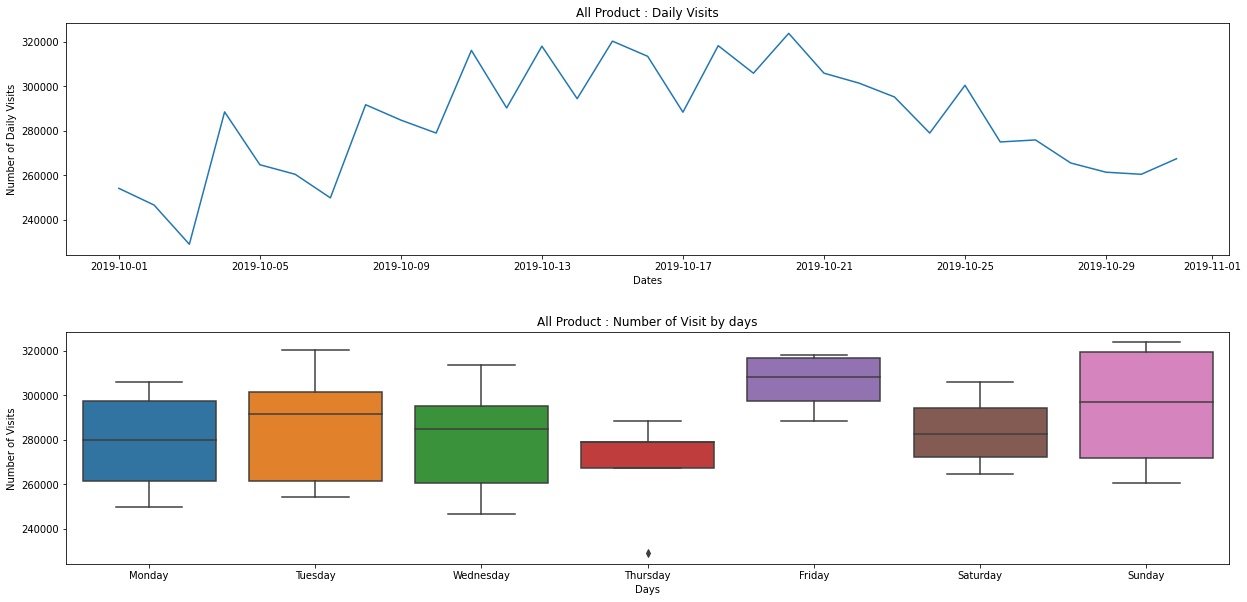

In [17]:
# 전체 제품군 대상 방문자 수 시각화

visits_visualization(daily_summary_table, 'All Product')

## Conversion 지표 정의

- Visit-Cart Conversion : 방문 수 대비 카트에 물건을 담은 수의 비율
- Visit-Purchase Conversion : 방문 수 대비 물건을 구매한 수의 비율
- Cart-Purchase Conversion : 카트에 물건을 담은 수 대비 물건을 구매한 수의 비율


## Visit-Purchase Conversion
- 월, 토, 일 Visit-Purchase conversion이 비교적 높음
- 방문율 1위는 금요일이지만, Visit-Purchase Conversion은 평일과 비슷함
- **금요일에 물건을 판매할 수 있는 기회를 놓치고 있음**

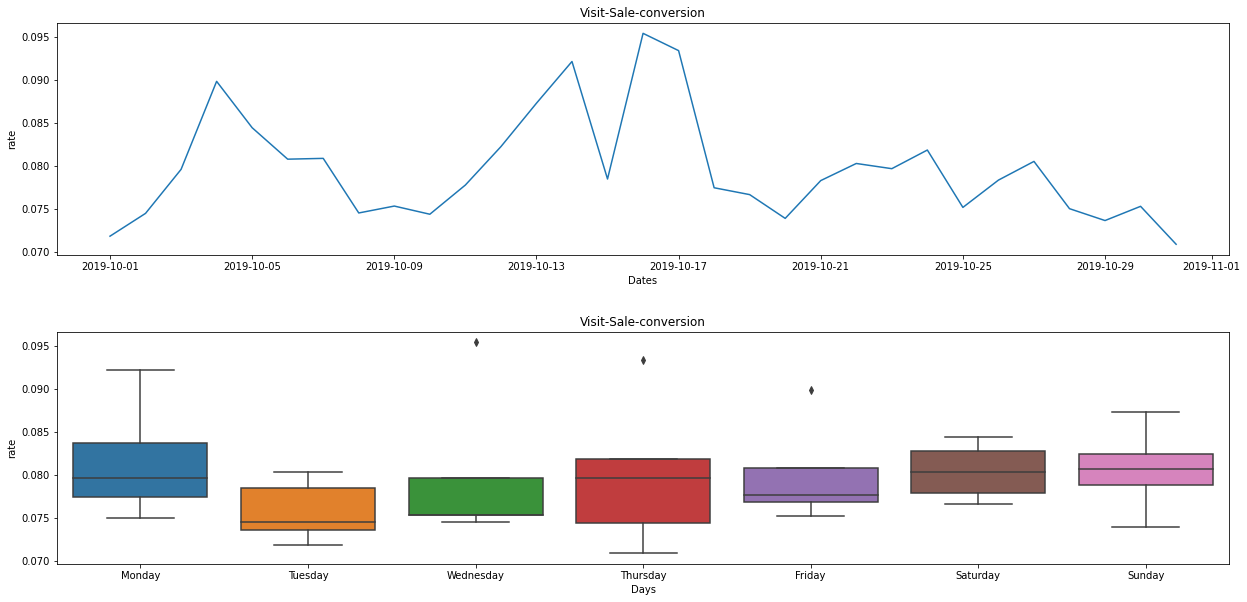

In [18]:
# 통상적인 임금일 전후로 Conversion이 높음
# 월, 토, 일이 방문-구매 conversion이 비교적 높음 
# 금요일은 방문수를 생각했을 때 구매율이 다소 저조한 편임(방문율 1위는 금 but Conversion은 평일과 비슷함)
# 물건을 판매할 수 있는 기회를 놓치고 있다?

fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
sns.lineplot(x='event_time',
              y='Visit-Sale-conversion',
              data=conversion_table,
             ax=ax1)
#plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Visit-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Dates')

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=conversion_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=conversion_table['Visit-Purchase-conversion'],
            ax=ax2)
#plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Visit-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

## EDA - 제품별 Conversion 분석
- Conversion이 떨어지는 제품이 있는지 확인
- 제품군에 따라 Conversion에 특징이 있는지 확인

In [19]:
# EDA 관련 함수 모음

def make_category_df(df_full, categori):
    # 대분류 카테고리별 df 만드는 함수

    df_cate = df_full.loc[df_full['category_code_level_1'] == categori]
    df_cate['category_code_level_2'] = df_cate['category_code'].str.split(".", expand=True)[1]
    return df_cate

def make_product_conversion(df_temp):
    # 제품 별 Conversion 테이블 만드는 함수
    # Groupby and Pivot
    df_cate_action = df_temp.groupby(['category_code_level_2', 'event_type']).size().to_frame().reset_index()
    df_cate_action = pd.pivot_table(df_cate_action, index = ['category_code_level_2'], columns = ['event_type'], values = 0).reset_index()

    # Conversion 계산
    df_cate_action['total'] = df_cate_action['cart'] + df_cate_action['purchase'] + df_cate_action['view']
    df_cate_action['view_purchase_con'] = df_cate_action['purchase'] / df_cate_action['view']
    df_cate_action['view_cart_con'] = df_cate_action['cart'] / df_cate_action['view']
    df_cate_action['cart_purchase_con'] = df_cate_action['purchase'] / df_cate_action['cart']
    
    return df_cate_action



In [20]:
# 대분류 칼럼 생성

df["category_code_level_1"] = df["category_code"].str.split(".", expand=True)[0]
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category_code_level_1
0,2019-10-01 00:00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,NaN
1,2019-10-01 00:00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,appliances
2,2019-10-01 00:00:01,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,furniture
3,2019-10-01 00:00:01,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,computers
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics


In [21]:
# 대분류 아이템의 비율 확인
# 상위 세 그룹의 아이템만 분석에 포함

rate_category = df.category_code_level_1.value_counts(normalize=True)
categori_list = df.category_code_level_1.unique()

print(rate_category)

electronics     0.557926
appliances      0.171733
computers       0.080319
apparel         0.053194
furniture       0.042979
auto            0.035031
construction    0.025260
kids            0.017986
accessories     0.008215
sport           0.006099
medicine        0.000512
country_yard    0.000487
stationery      0.000261
Name: category_code_level_1, dtype: float64


In [23]:
# Memory-out 문제에 대응하기 위해 제품군 별로 테이블 분리

df_elec = make_category_df(df, 'electronics')
df_appli = make_category_df(df, 'appliances')
df_com = make_category_df(df, 'computers')

In [ ]:
# 금요일만 분석할 때 주석 해제 후 코드 실행

"""

df_elec['event_time'] = df_elec['event_time'].dt.dayofweek
df_appli['event_time'] = df_appli['event_time'].dt.dayofweek
df_com['event_time'] = df_com['event_time'].dt.dayofweek

df_elec = df_elec.loc[df_elec['event_time'] == 4]
df_appli = df_appli.loc[df_appli['event_time'] == 4]
df_com = df_com.loc[df_com['event_time'] == 4]

"""

### Electronics Conversion 분석
- 전자 제품군 안에서도 Conversion에 편차가 있음(0.03 ~ 0.01)
- 특정 브랜드의 강세가 뚜렷함(Samsung, Apple)
- 같은 제품군 안에서도 Conversion에 차이가 있는 이유는 무엇일까?
    - 가격 편차와 전환율의 관계 분석 필요

In [24]:
# 전자제품 중 세부 카테고리의 비율

df_elec['category_code_level_2'].value_counts(normalize=True)

smartphone    0.713333
audio         0.097573
clocks        0.081116
video         0.069821
tablet        0.019633
telephone     0.015343
camera        0.003182
Name: category_code_level_2, dtype: float64

In [25]:
# electorinic Conversion
# 카메라는 보고(view) 카드에 담는 확률은 낮지만(0.01), 카드에 담으면 구매확률이 매우 높아짐(0.92)
# 가격은 스마트폰이 더 비싼데, 카트에 담지 않고 구매하는 비율은 더 높음 -> 브랜드 수의 차이 때문일까? -> 지배적인 브랜드가 있으면 별로 고민하지 않고 그 브랜드를 살 것
# 시계 브랜드도 압도적인 시장이 있는데 카트 비율이 높다 -> 스마트워치에 대한 필요성, 효용성에 대한 설득이 다른 전자기기에 비해 아직 덜 된 편
# 스마트워치는 주로 스마트폰의 브랜드에 맞춰 구매함 -> 애플 워치의 비율이 높음 -> 그렇다면, 고민하지 않고 바로 구매할 수 있도록 판촉해야 하지 않을까? -> 효용성에 대한 제시
# 브랜드 담당자가 아니기 때문에 브랜드 분석까지는 안해도 될 것 같음

df_elec_conv = make_product_conversion(df_elec)
df_elec_conv.sort_values('view_purchase_con')

event_type,category_code_level_2,cart,purchase,view,total,view_purchase_con,view_cart_con,cart_purchase_con
1,camera,564,524,50220,51308,0.010434,0.011231,0.929078
2,clocks,20335,17906,1269744,1307985,0.014102,0.016015,0.880551
5,telephone,5342,3738,238317,247397,0.015685,0.022416,0.699738
4,tablet,9132,5603,301839,316574,0.018563,0.030255,0.613557
6,video,36366,21647,1067848,1125861,0.020272,0.034055,0.595254
0,audio,52678,35592,1485085,1573355,0.023966,0.035471,0.675652
3,smartphone,549743,338018,10614666,11502427,0.031844,0.051791,0.614865


In [26]:
df_elec_unique = df_elec.drop_duplicates('product_id')
df_elec_unique.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category_code_level_1,category_code_level_2
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics,smartphone
9,2019-10-01 00:00:11,view,1004545,2053013555631882655,electronics.smartphone,huawei,566.01,537918940,406c46ed-90a4-4787-a43b-59a410c1a5fb,electronics,smartphone
11,2019-10-01 00:00:11,view,1005011,2053013555631882655,electronics.smartphone,samsung,900.64,530282093,50a293fb-5940-41b2-baf3-17af0e812101,electronics,smartphone
16,2019-10-01 00:00:18,view,1801995,2053013554415534427,electronics.video.tv,haier,193.03,537192226,e3151795-c355-4efa-acf6-e1fe1bebeee5,electronics,video
19,2019-10-01 00:00:19,view,1005135,2053013555631882655,electronics.smartphone,apple,1747.79,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics,smartphone


In [28]:
# 스마트폰 판매비율 상위 5개 브랜드

df_smartphone_rate = df_elec['brand'].loc[(df_elec['category_code_level_2'] == 'smartphone') & (df_elec['event_type'] == 'purchase')].value_counts(normalize=True).round(3).to_frame()
df_smartphone_rate.head()

,brand
samsung,0.424
apple,0.342
xiaomi,0.115
huawei,0.065
oppo,0.032


In [29]:
# 판매비율 상위 5개 브랜드의 가격에 대한 기술통계
# 가격 분포가 고를 수록 Cart에 담고 심사숙고할 가능성이 높을까?

df_elec_unique.loc[df_elec_unique['category_code_level_2'] == 'smartphone'].groupby(['brand']).price.describe().reset_index().sort_values('mean', ascending = False).head()

,brand,count,mean,std,min,25%,50%,75%,max
0,apple,150.0,1045.835267,413.238003,360.08,746.200,1006.335,1300.455,2072.10
9,google,10.0,764.358000,180.024300,540.30,585.605,823.625,882.685,1055.11
26,oneplus,21.0,647.402381,151.139943,367.35,540.300,646.370,759.350,874.67
35,umi,2.0,617.750000,218.411143,463.31,540.530,617.750,694.970,772.19
30,samsung,155.0,534.495226,356.549834,77.14,231.135,409.020,771.935,1544.42


### Appliances 분석
- 제품군 안에서도 Conversion에 편차가 있음(0.023 ~ 0.013)
- 전자 제품군과 비교하면 편차가 적은 편
  - 전자 제품군과 전환율에 차이가 있는 이유는 무엇일까?
  - 같은 제품군안에서도 전환율에 차이가 있는 이유는 무엇일까?

In [30]:
# 생활용품은 카트에 담기보다 바로 구매하는 경우가 많음(카트에 잘 담지 않음)

df_appli_conv = make_product_conversion(df_appli)
df_appli_conv.sort_values('view_purchase_con', ascending=False)

event_type,category_code_level_2,cart,purchase,view,total,view_purchase_con,view_cart_con,cart_purchase_con
1,iron,4093,3653,157493,165239,0.023195,0.025988,0.892499
2,ironing_board,354,664,34227,35245,0.019400,0.010343,1.875706
4,personal,2704,2542,144211,149457,0.017627,0.018750,0.940089
0,environment,24522,18074,1103890,1146486,0.016373,0.022214,0.737052
3,kitchen,58370,48124,3208172,3314666,0.015000,0.018194,0.824465
5,sewing_machine,2287,1939,148014,152240,0.013100,0.015451,0.847836


### Computers 분석
- 제품군 안에서도 Conversion에 편차가 있으나, 앞선 제품에 비하면 편차가 작은 편(0.014 ~ 0.007)

In [31]:
# 컴퓨터(용품)은 카트에 담기보다 바로 구매하는 경우가 많음
# view 대비 구매 비율은 다소 낮음 

df_com_conv = make_product_conversion(df_com)
df_com_conv.sort_values('view_purchase_con', ascending=False)

event_type,category_code_level_2,cart,purchase,view,total,view_purchase_con,view_cart_con,cart_purchase_con
3,notebook,15627,15590,1104823,1136040,0.014111,0.014144,0.997632
4,peripherals,6092,5225,376658,387975,0.013872,0.016174,0.857682
0,components,2006,3514,338049,343569,0.010395,0.005934,1.751745
2,ebooks,476,294,29060,29830,0.010117,0.016380,0.617647
1,desktop,3229,3232,417463,423924,0.007742,0.007735,1.000929


## 가격 표준편차와 Conversion 간의 상관관계 분석
- 같은 제품군 안에서 전환율에 편차가 발생하는 이유 분석
- 가격 편차를 비교할 수 있는 수치로 바꾸기 위해 변동 계수 활용
- 산포도를 통해 X-Y 축 위에서 제품을 그룹화함

In [34]:
def make_std_table(df_temp):
    df_sta = df_temp.groupby(['category_code_level_2', 'event_type']).price.describe().reset_index()
    df_sta['scale_std'] = df_sta['std'] / df_sta['mean']
    df_sta_fin = df_sta.loc[df_sta['event_type'] == 'cart'].reset_index(drop=True)
    df_sta_fin['view_counts'] = df_sta['count'].loc[df_sta['event_type']=='view'].reset_index(drop=True)
    df_sta_fin['purchase_counts'] = df_sta['count'].loc[df_sta['event_type']=='purchase'].reset_index(drop=True)
    df_sta_fin['view_cart_conversion'] = df_sta_fin['count'] / df_sta_fin['view_counts']
    df_sta_fin['view_purchase_conversion'] = df_sta_fin['purchase_counts'] / df_sta_fin['view_counts']
    df_sta_fin['cart_purchase_conversion'] = df_sta_fin['purchase_counts'] / df_sta_fin['count']

    return df_sta_fin

### Electronics

- A군 : 가격의 표준편차가 낮고, 판매 전환율이 낮은 제품군
  - camera, clocks, telephone
  - 주로 대체제가 있는 상품들로 효용성에 대한 고민이 있을 수 있음
  - Action Plan : 사야할 이유를 제시해야 함
- B군 : 가격의 표준편차가 낮고, 판매 전환율이 높은 제품군 
    - video, audio
    - 가전 필수 제품(주로 tv, 이어폰/헤드셋)
    - 전환율이 상대적으로 높기 때문에 Action Plan의 대상에서 제외함
- C군 : 가격의 표준편차가 크고, 판매 전환율이 낮은 제품군 
    - tablet 
    - 가격 대비 실용성의 고민이 있을 수 있음 
    - Action Plan : 예상보다 높은 가격으로 인해 구매를 망설일 가능성이 높기 때문에 프로모션의 대상됨
- D군 : 가격의 표준편차가 크고, 판매 전환율이 높은 제품군 
    - smartphone
    - 압도적인 브랜드가 있는 제품군(samsung, apple)으로, 가격 편차가 크더라도 해당 브랜드에 대한 구매가 이루어짐
    - 전환율이 상대적으로 높기 때문에 Action Plan의 대상에서 제외함


In [35]:
df_elec_sta = make_std_table(df_elec)

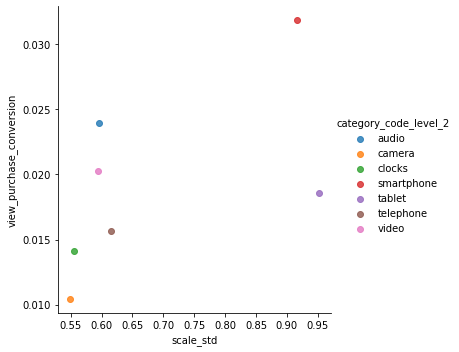

In [41]:
scatter = sns.lmplot(x='scale_std', y='view_purchase_conversion', data=df_elec_sta, hue = 'category_code_level_2')

In [42]:
X = df_elec_sta.scale_std
Y = df_elec_sta.view_purchase_conversion
np.corrcoef(X, Y)[0, 1]

0.5892499823786989

### Appliances
- A군 : 가격의 표준편차가 낮고, 판매 전환율이 낮은 제품군
    - environment(청소 용품), kitchen(주방 용품), personal(개인 위생 용품 등)
    - 평소 자주 사용하는 용품이지만 구매로 전환되지는 않음
    - Action Plan : 사야할 이유를 제시해야 함
- B군 : 가격의 표준편차가 낮고, 판매 전환율이 높은 제품군
    - ironing_board(다리미대) 
    - view 수는 가장 낮으나 전환율은 상대적으로 높은 것으로 보아 정말 필요한 사람만 찾아보는 제품임
    - 전환율이 상대적으로 높기 때문에 Action Plan의 대상에서 제외함
- C군 : 가격의 표준편차가 크고, 판매 전환율이 낮은 제품군 
    - sewing_machine(재봉틀) 
    - 일반적으로 쉽게 구매할 수 있는 제품은 아니며 필요한 사람들만 찾아보지만, 가격편차가 크기 때문에 구매를 망설임
    - Action Plan : 낮은 가격 대의 리뷰가 좋은 제품 추천
- D군 : 가격의 표준편차가 크고, 판매 전환율이 높은 제품군 
    - iron(다리미 등) 
    - view는 작지만 가격 편차가 크더라도 필요하다는 생각이 들면 꼭 구매를 하는 제품
    - 전환율이 상대적으로 높기 때문에 Action Plan의 대상에서 제외함


In [43]:
df_appli_sta = make_std_table(df_appli)
df_appli_sta

,category_code_level_2,event_type,count,mean,std,min,25%,50%,75%,max,scale_std,view_counts,purchase_counts,view_cart_conversion,view_purchase_conversion,cart_purchase_conversion
0,environment,cart,24522.0,129.349528,108.380536,5.68,64.02,102.94,141.29,1395.12,0.837889,1103890.0,18074.0,0.022214,0.016373,0.737052
1,iron,cart,4093.0,68.043435,88.229946,9.76,22.11,38.35,74.62,669.23,1.296671,157493.0,3653.0,0.025988,0.023195,0.892499
2,ironing_board,cart,354.0,41.520311,29.240601,7.70,15.42,40.93,51.45,180.16,0.704248,34227.0,664.0,0.010343,0.019400,1.875706
3,kitchen,cart,58370.0,250.347709,200.798254,5.12,89.83,231.64,341.80,2574.04,0.802077,3208172.0,48124.0,0.018194,0.015000,0.824465
4,personal,cart,2704.0,29.958565,23.153595,7.70,11.81,23.14,44.85,149.27,0.772854,144211.0,2542.0,0.018750,0.017627,0.940089
5,sewing_machine,cart,2287.0,185.621377,227.730065,70.66,92.32,110.63,180.10,1797.77,1.226853,148014.0,1939.0,0.015451,0.013100,0.847836


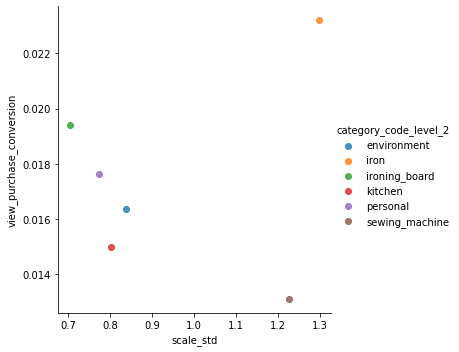

In [48]:
scatter = sns.lmplot(x='scale_std', y='view_purchase_conversion', hue = 'category_code_level_2', data=df_appli_sta)

In [49]:
X = df_appli_sta.scale_std
Y = df_appli_sta.view_purchase_conversion
np.corrcoef(X, Y)[0, 1]

0.16867164584585423

### Computers

- A군 : 가격의 표준편차가 낮고, 판매 전환율이 낮은 제품군
    - ebook 
    - 대체재가 많기 떄문에 효용성에 대한 고민이 있을 수 있음
    - Action Plan : 사야할 이유를 제시해야 함
- B군 : 가격의 표준편차가 낮고, 판매 전환율이 높은 제품군
    - notebook, peripherals(주변기기)
    - 전환율이 상대적으로 높기 때문에 Action Plan의 대상에서 제외함
- C군 : 가격의 표준편차가 크고, 판매 전환율이 낮은 제품군 
    - components(컴퓨터 부품), desktop
    - 제품 간 가격 편차가 커서 가격 비교를 많이 하는 대표적인 제품
    - Action Plan : 가격대 별로 제품의 성능과 용도를 구분하여 추천해야 함 
- D군 : D군은 없음

In [50]:
df_com_sta = make_std_table(df_com)
df_com_sta

,category_code_level_2,event_type,count,mean,std,min,25%,50%,75%,max,scale_std,view_counts,purchase_counts,view_cart_conversion,view_purchase_conversion,cart_purchase_conversion
0,components,cart,2006.0,109.029501,135.038069,7.40,38.330,64.400,147.01,1403.12,1.238546,338049.0,3514.0,0.005934,0.010395,1.751745
1,desktop,cart,3229.0,256.704618,385.596064,5.08,47.290,93.660,308.86,2574.04,1.502100,417463.0,3232.0,0.007735,0.007742,1.000929
2,ebooks,cart,476.0,153.939076,54.669767,72.02,102.700,153.835,185.08,254.81,0.355139,29060.0,294.0,0.016380,0.010117,0.617647
3,notebook,cart,15627.0,611.017225,364.769809,7.36,334.600,514.630,720.22,2393.86,0.596988,1104823.0,15590.0,0.014144,0.014111,0.997632
4,peripherals,cart,6092.0,164.921077,126.074938,1.30,97.555,147.560,221.34,1105.79,0.764456,376658.0,5225.0,0.016174,0.013872,0.857682


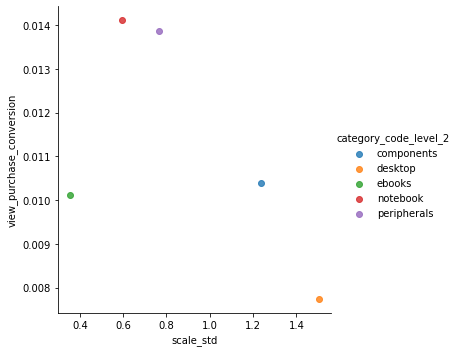

In [52]:
# A군 : 전환율이 낮고, 가격 편차도 작음 : ebook -> 효용성에 대한 고민?(대체제가 많음)
# B군 : 전환율이 높고, 가격 편차가 작음 : notebook, peripherals(주변기기)
# C군 : 전환율이 낮고, 가격 편차가 큼 : components(컴퓨터 부품), desktop -> 제품 간 가격 편차가 커서 가격 비교를 많이 하는 대표적인 제품

scatter = sns.lmplot(x='scale_std', y='view_purchase_conversion', hue = 'category_code_level_2', data=df_com_sta)

In [53]:
X = df_com_sta.scale_std
Y = df_com_sta.view_purchase_conversion
np.corrcoef(X, Y)[0, 1]

-0.590033744129481